# Weighted MAXCUT Problem

## Problem Statement : 
The [MaxCut problem](https://en.wikipedia.org/wiki/Maximum_cut) is a well-known optimization problem in which the nodes of a given undirected graph have to be divided in two sets (often referred as the set of “white” and “black” nodes) such that the number of edges connecting a white node with a black node are maximized. The MaxCut problem is a problem on which the QAOA algorithm has proved to be useful (for an explanation of the QAOA algorithm you can read [this blogpost](https://www.mustythoughts.com/quantum-approximate-optimization-algorithm-explained)).

At [this link](https://lucaman99.github.io/new_blog/2020/mar16.html) you can find an explicit implementation of the QAOA algorithm to solve the MaxCut problem for the simpler case of an unweighted graph. We ask you to generalize the above code to include also the solution for the case of weighted graphs. You can use the same code or you can also do an alternative implementation using, for example, qiskit. The important point is that you do not make use of any built-in QAOA functionalities.

# Required Installation and Imports

In [ ]:
!pip install pennylane --upgrade

In [2]:
import pennylane as qml
from pennylane import numpy as np

# Test Cases

Each of the test cases here basically represented by three parameters. 

1. n_wires which denotes number of nodes in the graph as well as the number of qubits that  will be used in the quantum circuit. 

2. graph - each element of this list represents each edge of the graph by mentioning the number of two nodes of that edge. 

3. weight - this list contains information about the weights associated with each nodes. 

Importantly, the sequance of edges followed in the 'graph', the same sequence must be followed in the 'weight' too. 

In [3]:
n_wires = 3
graph = [(0,1), (1,2), (0,2)]
weight = [10, 1, 10]


# n_wires = 4
# graph = [(0, 1), (0, 3), (1, 2), (2, 3)]
# weight = [1, 1, 1, 1]

# n_wires = 6
# graph = [(0,1), (0,2), (1,2), (2,3), (3,4), (4,5), (3,5)]


# n_wires = 5
# graph = [(0,1), (0,2), (1,2), (1,3), (2,3), (3,4)]
# weight = [5, 1, 7, 4, 2, 3]




# Theoretical Discussion

The main moto of this problem is to seperate the whole set of nodes in two subsets $A$ and $B$ such that the sum of weights of edges that have different types of nodes at their ends become the maximum possible value. 

In other words, we have to find a partition through the whole graph, such that sum of weights of edges that the partition passes becomes the maximum among all possible cuts. 

We can convert this to a simple mathematical expression. 

>>>$C(z) = \sum \limits _{\alpha=1} ^{m} C_{\alpha}(z) $



Here $C(z)$ represents the score of a specific partition through the graph. $\alpha$ iterates from 1 to m where m is the number of edges present. for each edge, $C_{\alpha}(z)$ represents the score associated with each edge. $C_{\alpha}(z)$ is equal to the weight of the edge if the partition passes through that edge and equal to $0$, if not. 



# Representing in terms of Quantum Circuit

As we have already defined a score value for a cut, we have to define that in terms of unitary ooperators that can be implemented on the quantum circuit. 

While representing the partition using computational basis states, we can represent the terms in $C(z)$ as operators acting on the states. 

>>> $C_{\alpha} = \frac{1}{2} W (1-\sigma_z^j \sigma_z^k) $

Here the $\alpha$th edge is the edge connecting $j$th and $k$th nodes. For each node $C_{\alpha}$ will be equal to the weight of the edge if the partition goes between $j$th and $k$th nodes and equal to $0$ if doesn't pass because the operator $(1-\sigma_z^j \sigma_z^k)$ has eigenvalue $1$, iff $j$th and $k$th qubit have different z-axis measurement values. 




Initially the circuit is converted to equal superposition state by applying Hadamard gate in each individual qubit, also known as $|+_{n}>$ state. 

The circuit consists of $L$ layers of $U_B$ and $U_C$ gates. In each layer, one $U_B$ and one $U_C$ is associated with one $\beta$ and $\gamma$ parameter. Therefore each layers having 2 params $\beta$ and $\gamma$, the whole $L$ layered circuit is consist of $2L$ parameters. 

Now coming to each of the layers, $U_B$ is single qubit operator, implemented on each of the individual qubits and it is basically a $R_x$ gate with parameter $2\beta$. $U_C$ whereas acts on two qubits. It is implemented on those two nodes who are connected by an edge in the graph. $U_C$ is $R_z$ gate with parameter $\gamma$ sandwiched between two CNOT gates. 

## Defining $U_B$ operator

In [3]:
def U_B(beta):
    for qubit in range(n_wires):
        qml.RX(2*beta, wires=qubit)

## Defining $U_C$ operator

In [4]:
def U_C(gamma):
    for edge in graph:
        qubit1 = edge[0]
        qubit2 = edge[1]
        qml.CNOT(wires = [qubit1, qubit2])
        qml.RZ(gamma, wires = qubit2)
        qml.CNOT(wires = [qubit1, qubit2])


## Computational Basis Measurement

To sample a measurement of multiple qubits in computational basis, we define this Hermitian operator. The eigenvalues of the operator are the qubit measurement values in integer form.

In [5]:
def comp_basis_measurement(wires):
    n_wires = len(wires)
    return qml.Hermitian(np.diag(range(2 ** n_wires)), wires=wires)

# Creating the circuit

First we are creating a device with wires same as the number of nodes present in the graph

In [10]:
dev = qml.device("default.qubit", wires=n_wires, analytic=True, shots=1)

We will define a $PauliZ_2$, which will be used to measure the expectatio value at the end of the circuit

In [11]:
pauliZ = [[1, 0], [0, -1]]

pauliZ_2 = np.kron(pauliZ, pauliZ)

Now the total circuit we will define and call the operators as a function one by one we defined previously. 

Intially the circuit is initialized as zero state on each qubit. 

Then we will apply Hadamard on each qubit to create equal superposition. 

After that $U_C$ and $U_B$ operator will be called $L$ times, where $L$ stands for the number of layers decided. 

Finally, we measure expectation value of each of the edges on the PauliZ_2 basis defined previously. 

In [12]:
@qml.qnode(dev)
def circuit(gamma, beta, edge=None, layers=1):

    for qubit in range(n_wires):
        qml.Hadamard(wires = qubit)

    for l in range(layers):
        U_C(gamma[l])
        U_B(beta[l])

    if edge is None:
        return qml.sample(comp_basis_measurement(range(n_wires)))

    return qml.expval(qml.Hermitian(pauliZ_2, wires=edge))




# Optimization

In [36]:
def optimize_weighted_maxcut(layers = 1):

    print("No of Layers => ", layers)

    init_params = 0.01 * np.random.rand(2, layers)



    def obj_func(params):

        gamma = params[0]
        beta = params[1]

        score = 0
        
        for idx in range(n_wires):
            score -= 0.5 * weight[idx] * (1 - circuit(gamma, beta, edge=graph[idx], layers=layers))

        return score

    optimizer = qml.AdagradOptimizer(stepsize = 0.5)

    params = init_params

    n_iters = 100

    for iter in range(n_iters):
        params = optimizer.step(obj_func, params)

        if ((iter+1)%5 == 0):
            print ("Score after step {} => {: .7f}".format(iter+1, (-1)*obj_func(params)))

    n_samples = 100
    bit_strings = []

    for i in range(n_samples):
        gamma = params[0]
        beta = params[1]
        bit_string = int(circuit(gamma, beta, 
                                 edge = None, 
                                 layers = layers))
        bit_strings.append(bit_string)

        
    counts = np.bincount(np.array(bit_strings))
    most_freq_bit_string = np.argmax(counts)

    print("Optimized (gamma, beta) parameters:\n{}".format(params[:, :layers]))
    print("Most frequently sampled bit string is: {:03b}".format(most_freq_bit_string))

    return ((-1)*obj_func(params), bit_strings)

# Test case 1

In [37]:
n_wires = 3
graph = [(0,1), (1,2), (0,2)]
weight = [10, 1, 10]

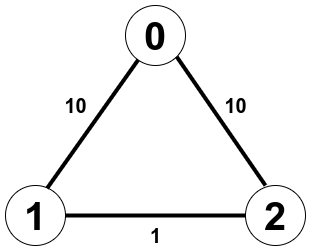

In [38]:
maxcut_result = optimize_weighted_maxcut(layers = 1)

No of Layers =>  1
Score after step 5 =>  13.0491262
Score after step 10 =>  13.7731035
Score after step 15 =>  13.9825451
Score after step 20 =>  13.9983912
Score after step 25 =>  13.9998561
Score after step 30 =>  13.9999870
Score after step 35 =>  13.9999988
Score after step 40 =>  13.9999999
Score after step 45 =>  14.0000000
Score after step 50 =>  14.0000000
Score after step 55 =>  14.0000000
Score after step 60 =>  14.0000000
Score after step 65 =>  14.0000000
Score after step 70 =>  14.0000000
Score after step 75 =>  14.0000000
Score after step 80 =>  14.0000000
Score after step 85 =>  14.0000000
Score after step 90 =>  14.0000000
Score after step 95 =>  14.0000000
Score after step 100 =>  14.0000000
Optimized (gamma, beta) parameters:
[[-0.61547971]
 [-1.26305647]]
Most frequently sampled bit string is: 010


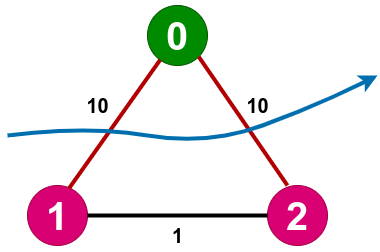